In [1]:
#!pip install tensorflow  
import tensorflow as tf
print(tf.__version__)

2023-01-23 18:12:00.771582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 18:12:00.885933: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-23 18:12:00.888740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ilker/Programs/GEANT4/InstallDir/geant4-v11.0.1/lib:/opt/OpenICEDA/lib:/opt/O

2.11.0


In [2]:
from __future__ import absolute_import,division,print_function,unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [3]:
import pathlib
data_dir=pathlib.Path("/media/ilker/Ilker/SimResults/Jan_20_2022/Particles")

In [4]:
image_count=len(list(data_dir.glob('*/*.png')))
print(image_count)

550


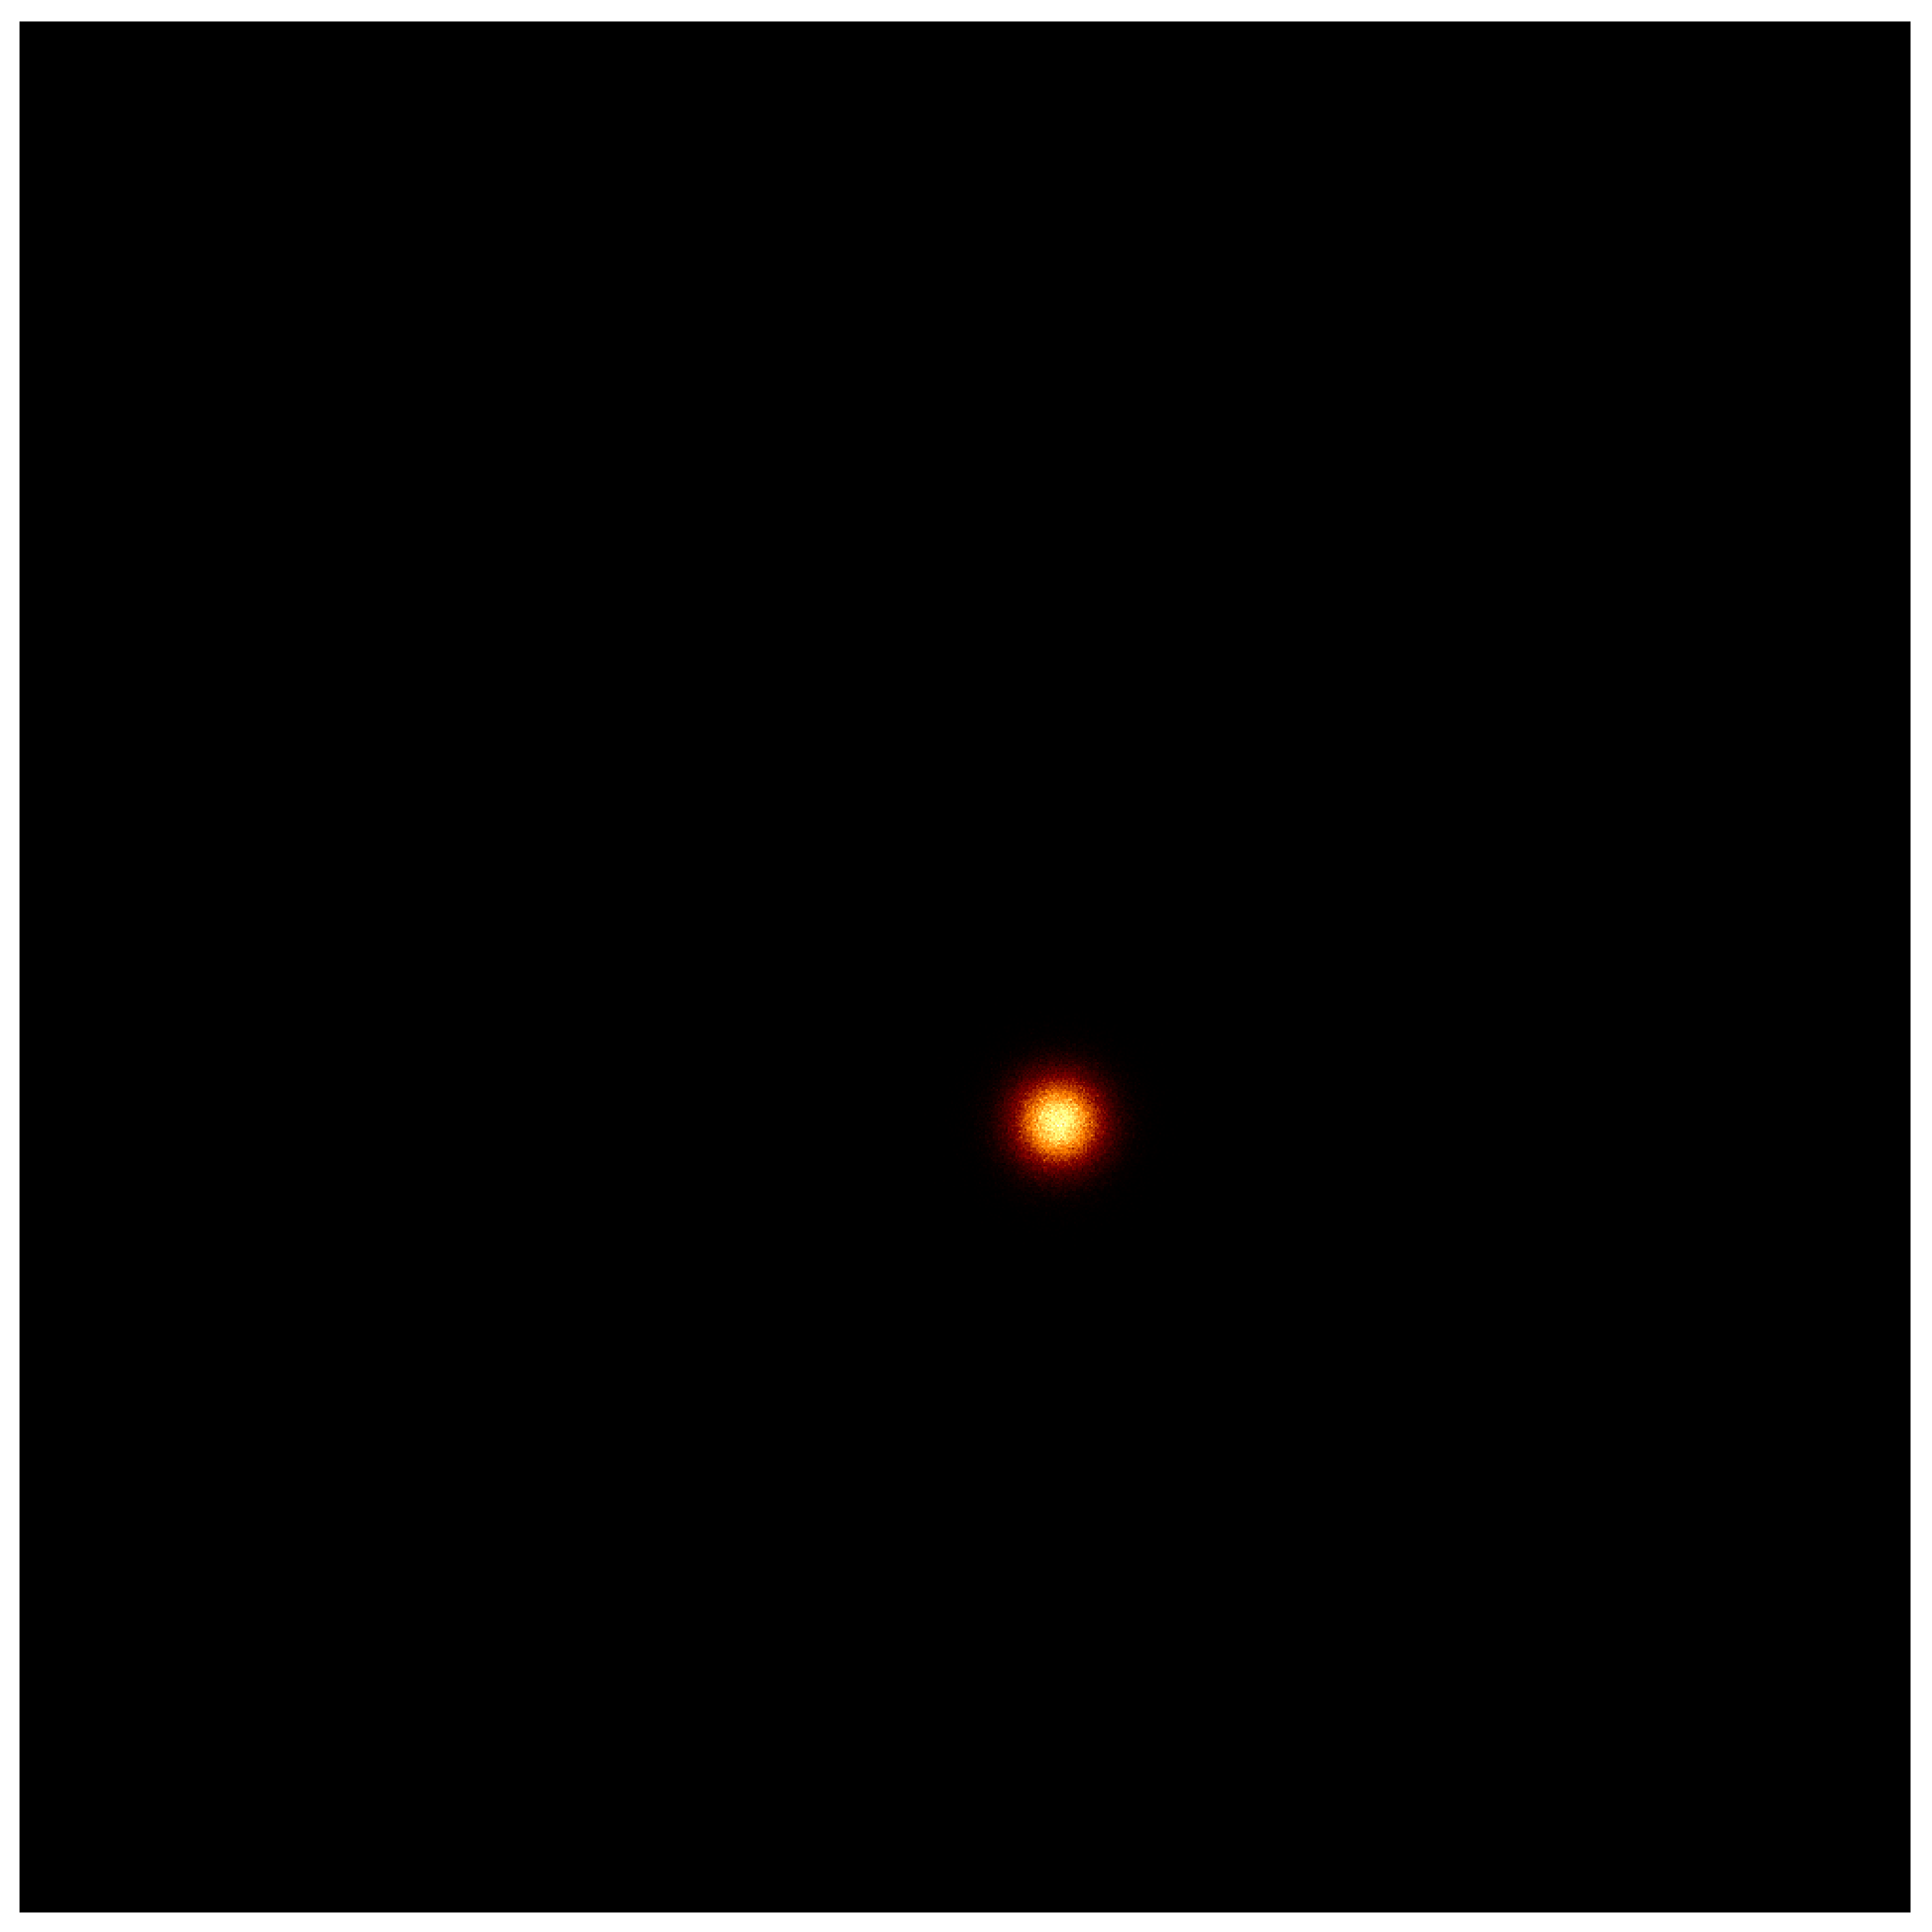

In [5]:
alphas=list(data_dir.glob('Alphas/*'))
PIL.Image.open(str(alphas[0]))

In [6]:
### Dataset
batch_size=35
img_h=180
img_s=3
#### Use your 80% images to train and 20% to validate

train_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_h,img_h),
    batch_size=batch_size
    #color_mode="grayscale",
    #shuffle=True
)

Found 550 files belonging to 2 classes.
Using 440 files for training.


2023-01-23 18:12:02.552967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 18:12:02.553568: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ilker/Programs/GEANT4/InstallDir/geant4-v11.0.1/lib:/opt/OpenICEDA/lib:/opt/OpenICEDA/src/klayout/bin-release:/home/ilker/Programs/root/build_cxx17/lib::/home/ilker/Programs/pythia6:/home/ilker/Programs/pythia8306/lib:/home/ilker/Programs/Generator/lib:/usr/lib/x86_64-linux-gnu/:/home/ilker/Programs/marley/build:/usr/lib/x86_64-linux-gnu
2023-01-23 18:12:02.553958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerr

In [7]:
val_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_h,img_h),
    batch_size=batch_size
    #color_mode="grayscale",
    #shuffle=True
)

Found 550 files belonging to 2 classes.
Using 110 files for validation.


In [8]:
class_names=train_ds.class_names

print(class_names)

['Alphas', 'Betas']


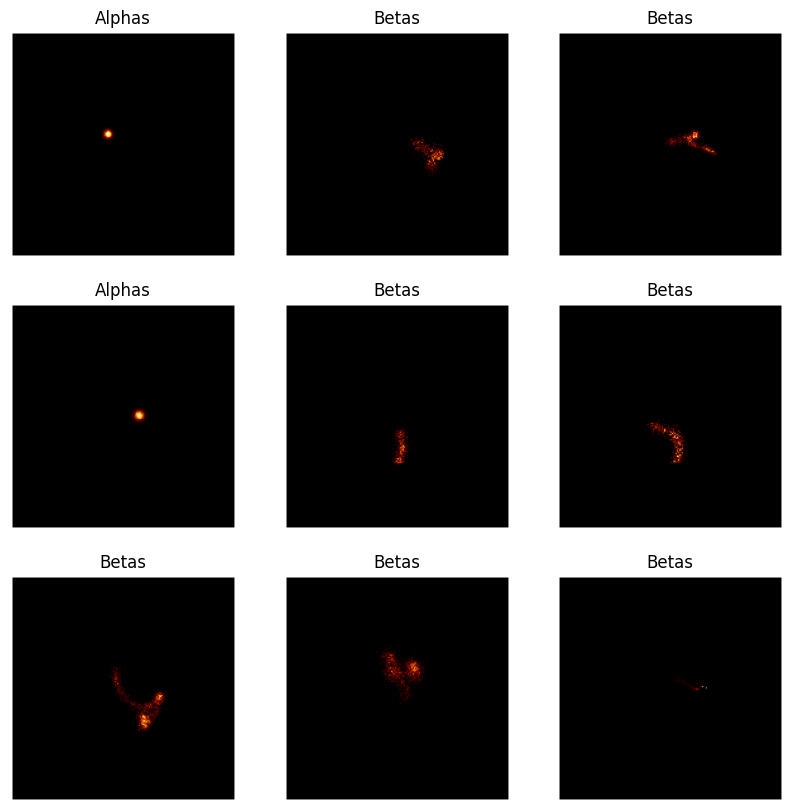

In [9]:
### Visualization of the images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'),cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")
        

In [10]:
for image_batch,labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(35, 180, 180, 3)
(35,)


In [11]:
### Configure thje dataset for the performance
autotune=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=autotune)
val_ds=val_ds.cache().prefetch(buffer_size=autotune)

In [12]:
### Standardize the data
norm_layer=layers.Rescaling(1/255)

In [13]:
from matplotlib import image
normalized_ds=train_ds.map(lambda x,y:(norm_layer(x),y))
image_batch,labels_batch=next(iter(normalized_ds))
print(np.min(image_batch[0]),np.max(image_batch[1]))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


In [14]:
#### Keras Model
### tf.keras.layers.
## Conv2D
## MaxPooling2D
## Dense

num_classes = len(class_names)
model= Sequential([
    layers.Rescaling(1/255,input_shape=(img_h,img_h,img_s)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding="same",activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes) 
])

In [15]:
#### Model Compilation
### tf.keras.losses
## SparseCategoricalCropssentropy loss function
## Adam

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [16]:
## Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [17]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
13/13 [==============================] - 4s 273ms/step - loss: 0.3763 - accuracy: 0.8409 - val_loss: 0.3324 - val_accuracy: 0.9000
Epoch 2/15
13/13 [==============================] - 2s 150ms/step - loss: 0.2856 - accuracy: 0.9114 - val_loss: 0.2634 - val_accuracy: 0.9000
Epoch 3/15
13/13 [==============================] - 2s 150ms/step - loss: 0.2028 - accuracy: 0.9114 - val_loss: 0.1466 - val_accuracy: 0.9000
Epoch 4/15
13/13 [==============================] - 2s 151ms/step - loss: 0.1382 - accuracy: 0.9114 - val_loss: 0.1431 - val_accuracy: 0.9000
Epoch 5/15
13/13 [==============================] - 2s 150ms/step - loss: 0.1157 - accuracy: 0.9114 - val_loss: 0.1304 - val_accuracy: 0.9000
Epoch 6/15
13/13 [==============================] - 2s 150ms/step - loss: 0.1059 - accuracy: 0.9136 - val_loss: 0.1029 - val_accuracy: 0.9455
Epoch 7/15
13/13 [==============================] - 2s 154ms/step - loss: 0.1025 - accuracy: 0.9409 - val_loss: 0.1099 - val_accuracy: 0.9364
Epoch 

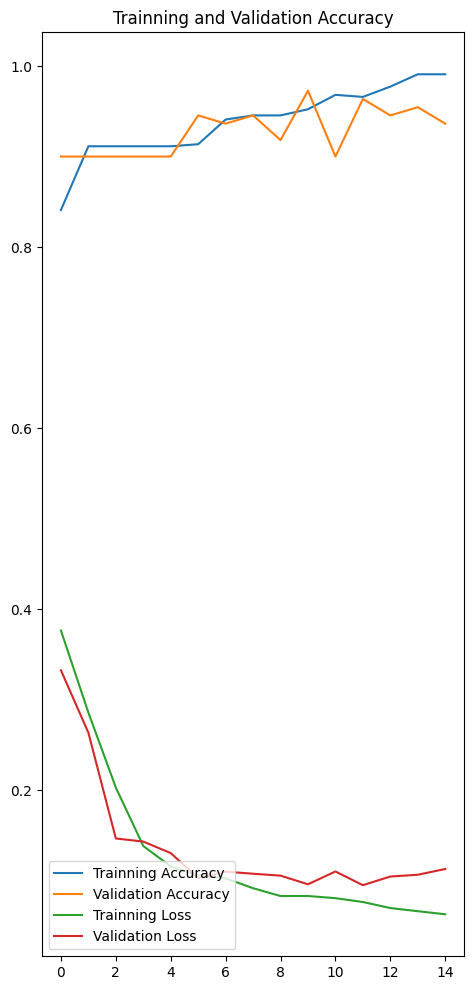

In [18]:
### Visualizing the Results

acc = history.history['accuracy']
val_acc=history.history['val_accuracy']
loss = history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(epochs)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Trainning Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Trainning and Validation Accuracy')
plt.subplot(1,2,1)
plt.plot(epochs_range,loss,label='Trainning Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='lower left')
plt.show()

In [19]:
#### Data Augmentation / Helps to improve training by applying transformation to images
### tf.keras.layers  
##  .RandomRotation
##  .RandomFlip
##  .RandomZoom

data_augmentation=keras.Sequential(
    [
        layers.RandomFlip("horizontal",input_shape=(img_h,img_h,img_s)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),

    ]
)


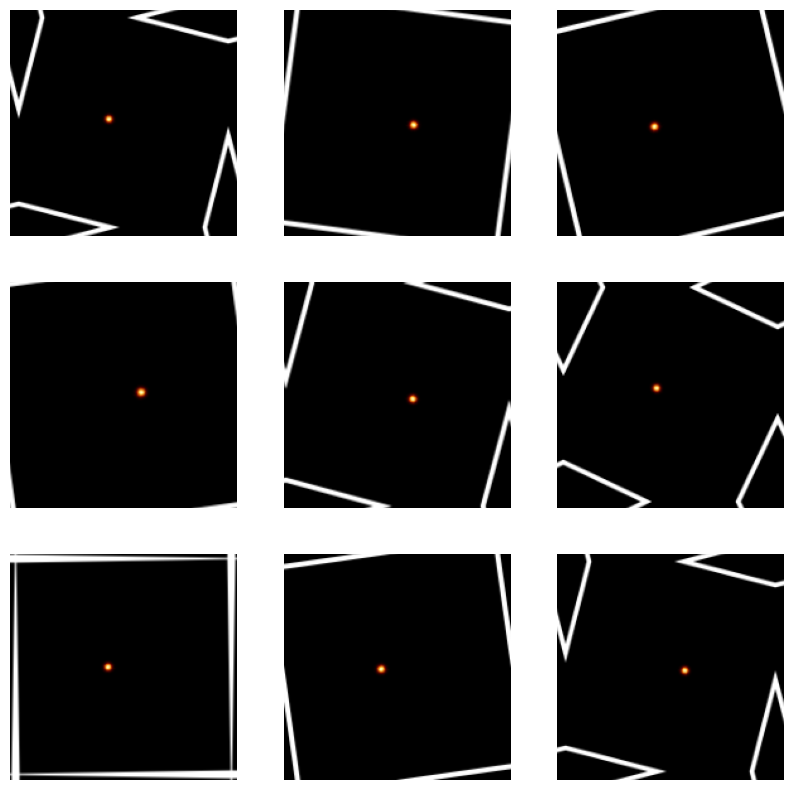

In [20]:
### Visualize a few augmented examples by appying data augmentation to the same image several times
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [21]:
#### Dropout -- An other technice to reduce overfitiing 
model=Sequential([
    data_augmentation,
    layers.Rescaling(1/255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes,name='output')
])


In [22]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

In [24]:
epochs=20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
13/13 [==============================] - 7s 386ms/step - loss: 0.7550 - accuracy: 0.8955 - val_loss: 0.5297 - val_accuracy: 0.9000
Epoch 2/20
13/13 [==============================] - 5s 395ms/step - loss: 0.3263 - accuracy: 0.9114 - val_loss: 0.2637 - val_accuracy: 0.9000
Epoch 3/20
13/13 [==============================] - 5s 398ms/step - loss: 0.1934 - accuracy: 0.9114 - val_loss: 0.1981 - val_accuracy: 0.9000
Epoch 4/20
13/13 [==============================] - 5s 397ms/step - loss: 0.1377 - accuracy: 0.9114 - val_loss: 0.1238 - val_accuracy: 0.9000
Epoch 5/20
13/13 [==============================] - 5s 410ms/step - loss: 0.1089 - accuracy: 0.9114 - val_loss: 0.1129 - val_accuracy: 0.9000
Epoch 6/20
13/13 [==============================] - 5s 392ms/step - loss: 0.1012 - accuracy: 0.9114 - val_loss: 0.1047 - val_accuracy: 0.9000
Epoch 7/20
13/13 [==============================] - 5s 395ms/step - loss: 0.0975 - accuracy: 0.9114 - val_loss: 0.0851 - val_accuracy: 0.9000
Epoch 

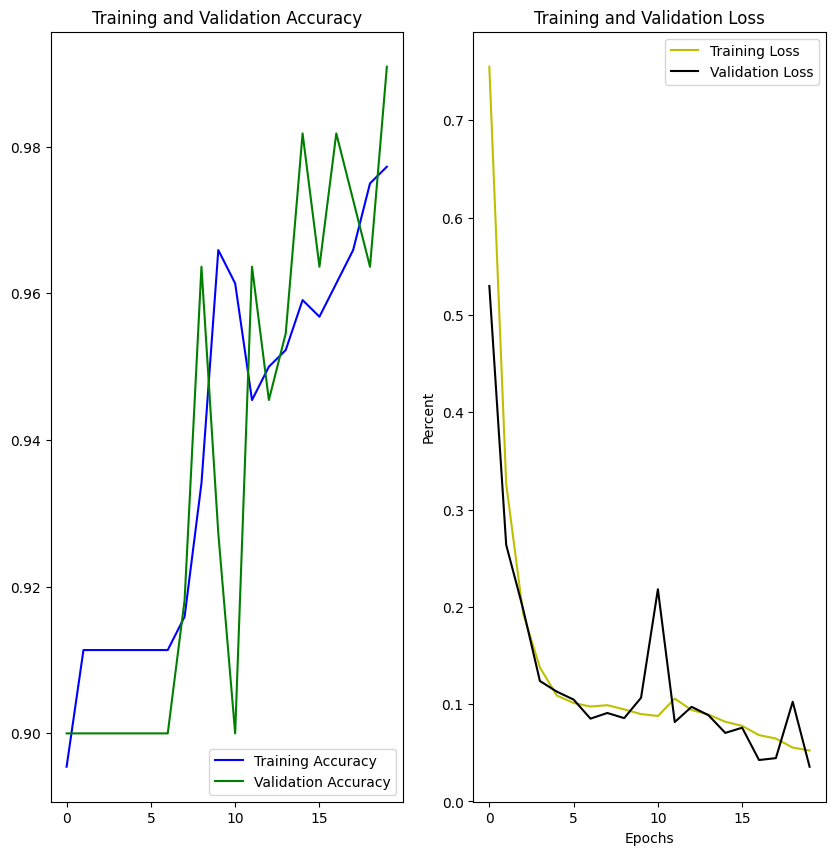

In [25]:
#### Visualize Trainning Results
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range= range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy',color="b")
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color="g")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color="y")
plt.plot(epochs_range, val_loss, label='Validation Loss',color="k")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Percent")
plt.show()

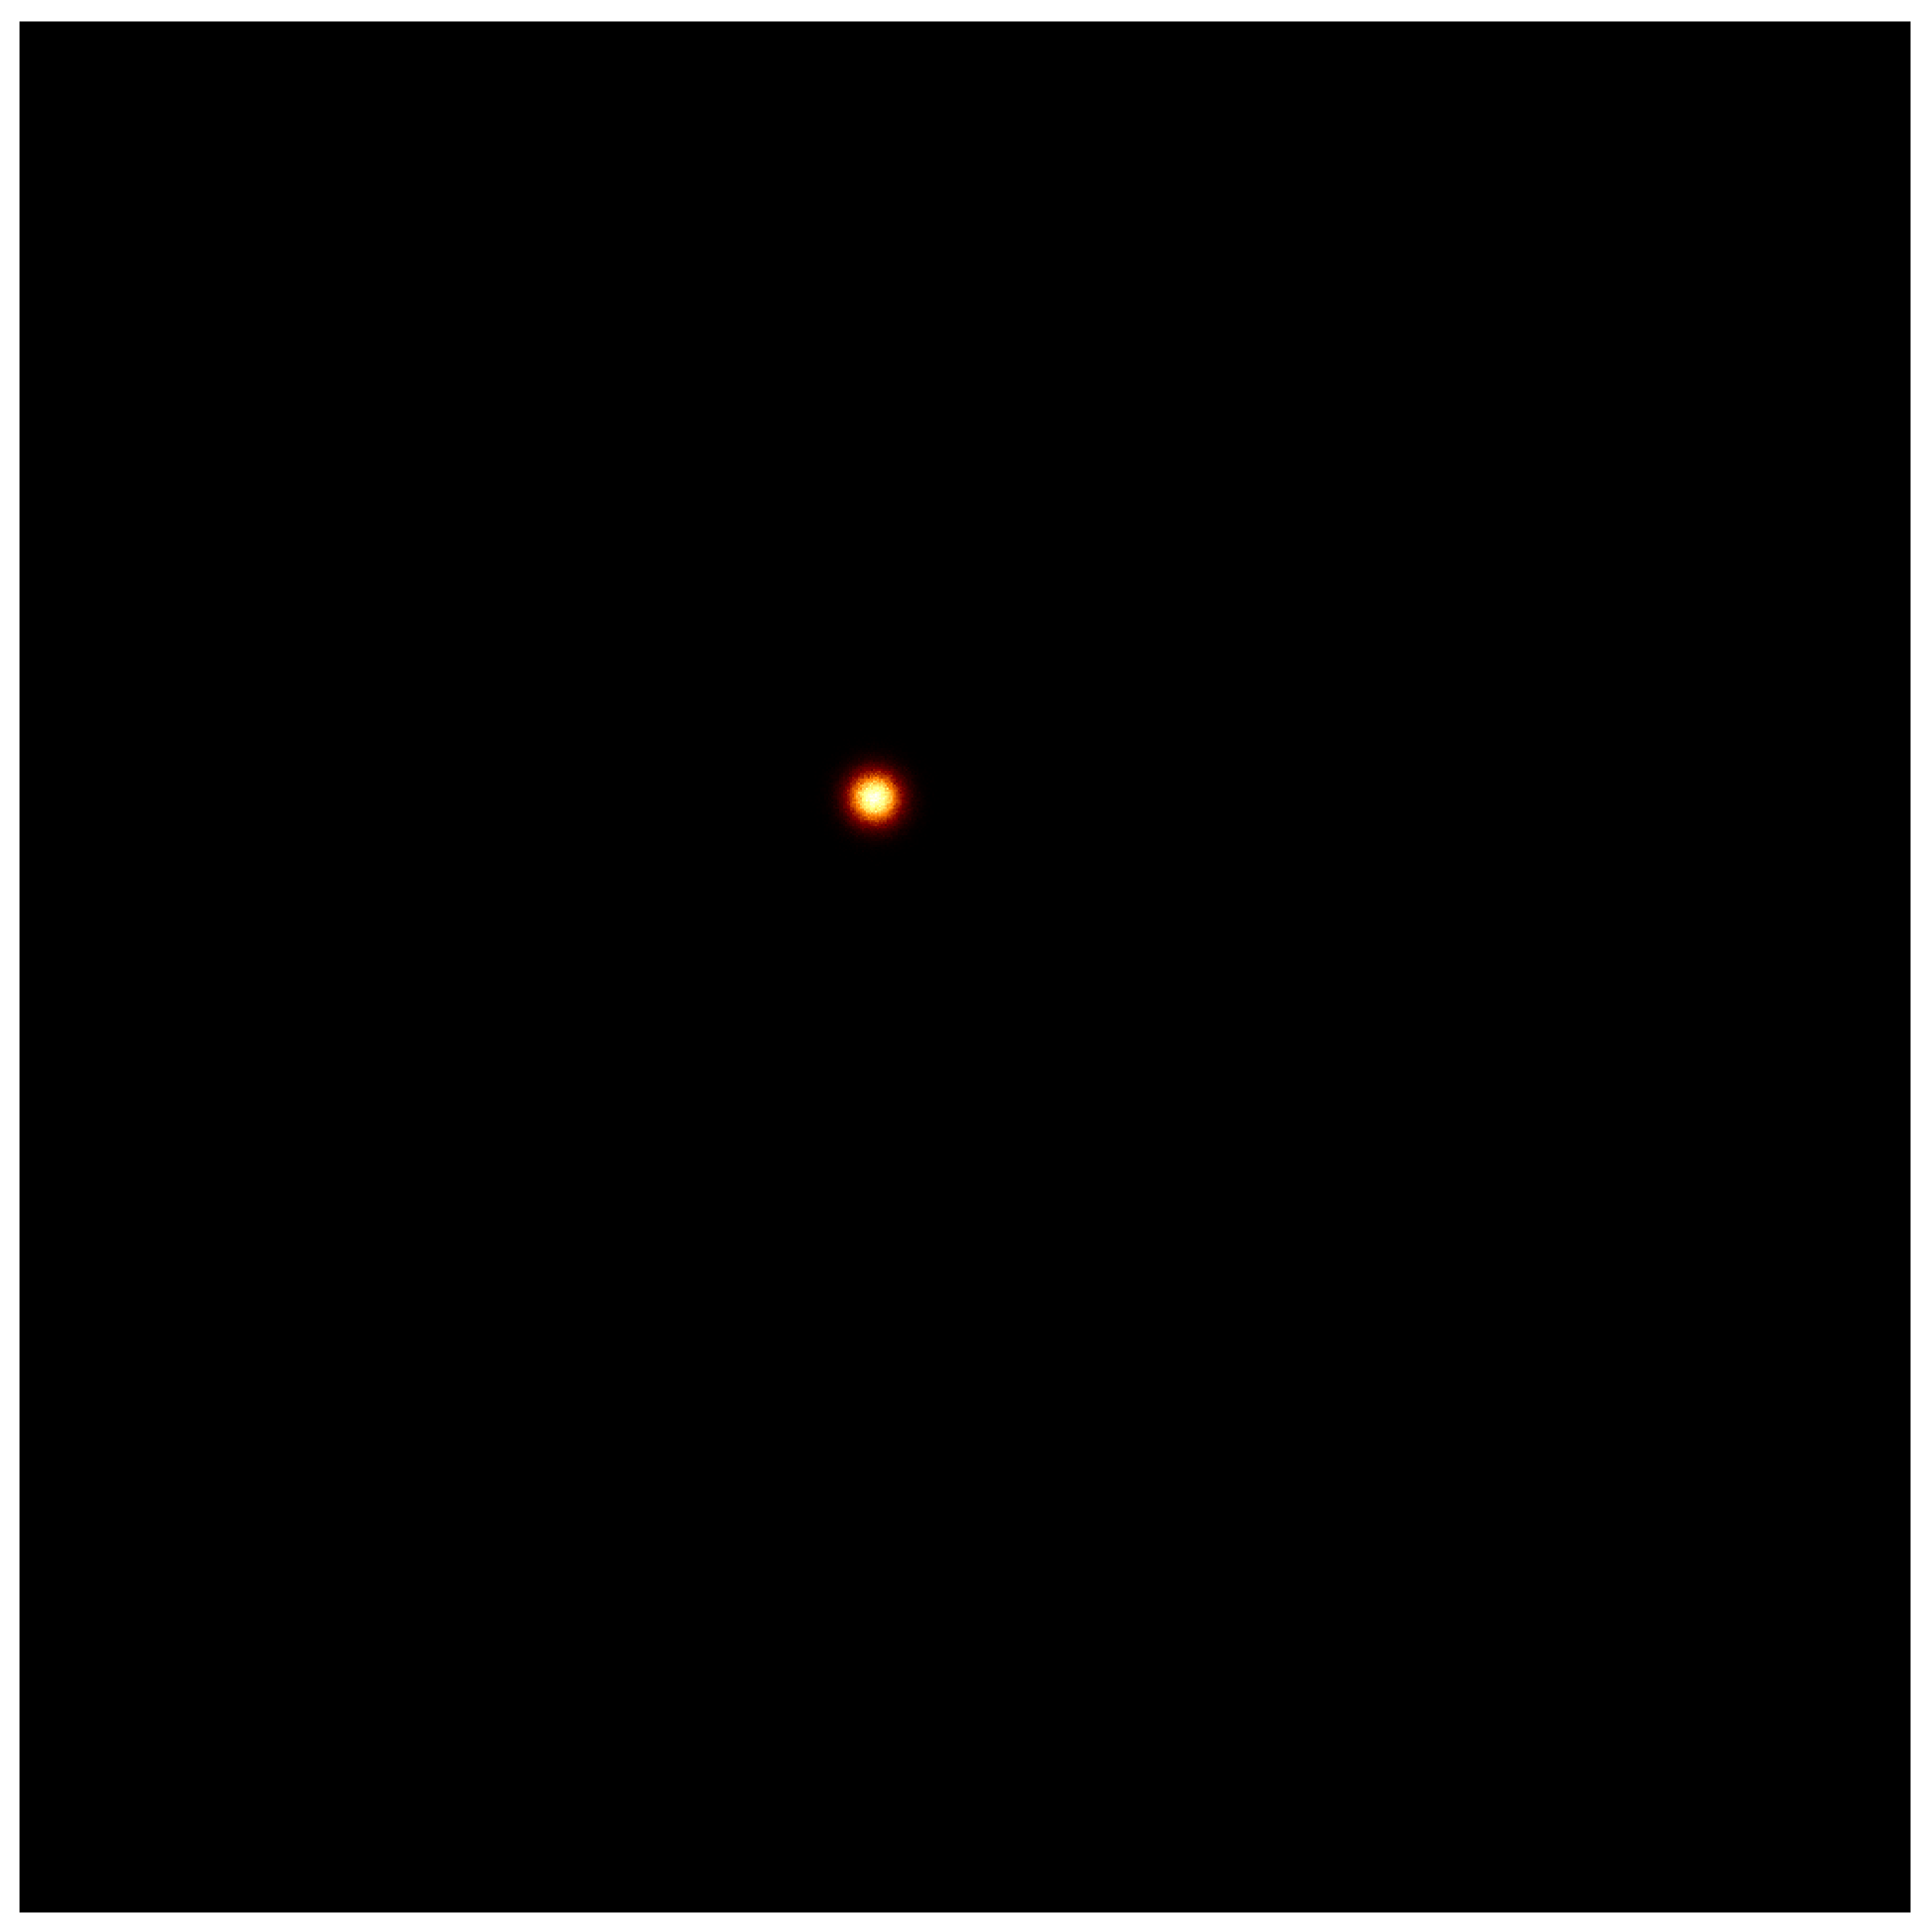

In [26]:
Predict_Alpha=pathlib.Path("/media/ilker/Ilker/SimResults/Jan_20_2022/Predictions")
alphas=list(Predict_Alpha.glob('Alpha/*'))
betas=list(Predict_Alpha.glob('Beta/*'))

PIL.Image.open(str(alphas[0]))

1/1 [==============================] - 0s 16ms/step
This image most likely belongs to Betas with a 100.00 percent confidence.


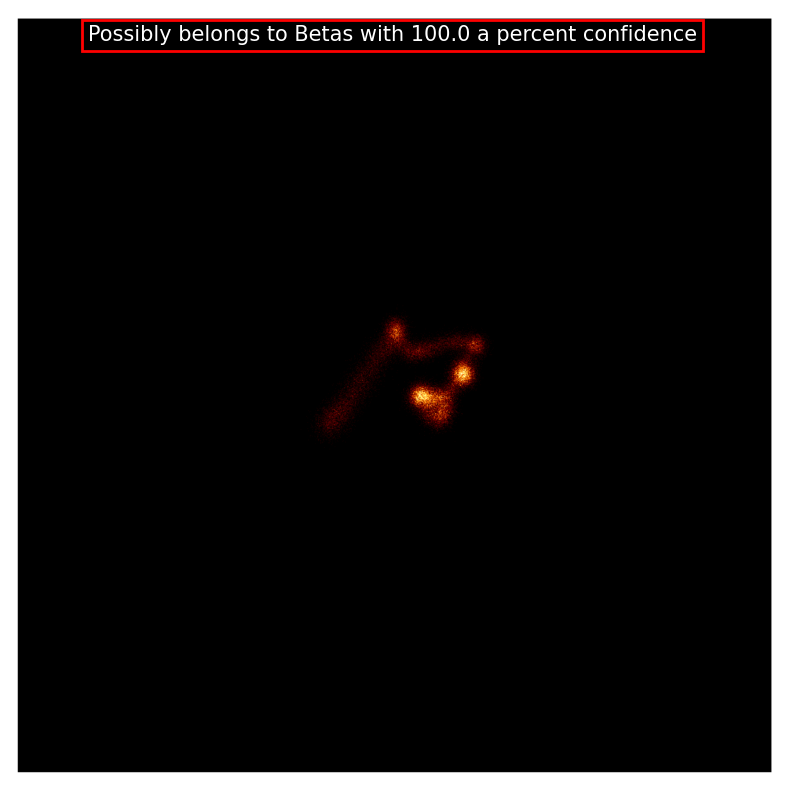

In [33]:
### Predictions
testedimg=betas[4]
img=tf.keras.utils.load_img(
    testedimg,target_size=(180,180)
)
img_array=tf.keras.utils.img_to_array(img)
img_array=tf.expand_dims(img_array,0) ### Create a batch
predictions=model.predict(img_array)
score=tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)],100*np.max(score))
)
k=plt.imread(testedimg)
fig,ax=plt.subplots(figsize=(10,10))

plt.axis("off")
s="Possibly belongs to " + class_names[np.argmax(score)] +" with " + str(round(100*np.max(score),2))+ " a percent confidence"
plt.text(300,120,s,fontsize=15,color="white",bbox=dict(fill=False, edgecolor='red',linewidth=2))
im=ax.imshow(k)
